# Scattered points, scattered bases
This workbook is a revised attempt at constructing a simulation of a stochastic dynamical system, with an accompanying estimation of the transfer operator.

In [592]:
include("functions.jl");

## Setting up the dynamics
The state space $X$ of our dynamical system will be the flat torus $\mathbb{T}^2$, represented by the square $[0, 2\pi] \times [0, 2\pi]$.

In [593]:
range = 2π;

For most numerical work, we will require a fine reference grid of points.

In [594]:
grid_size = 100;
n_gridpoints = grid_size ^ 2;
grid = creategrid(0, range, grid_size);

### A dynamical map
The particular map $S: \mathbb{T}^2 \to \mathbb{T}^2$ chosen to introduce the dynamics is the standard map, or Chirikov–Taylor map, given by
$$
S ([x , y]) := \begin{bmatrix} x + y \\ y + a \sin ( x + y) \end{bmatrix} \mod 2\pi
$$
where $a$ is a parameter which controls the amount of chaos. For the moment we take this to be $a=6$.

In this setup, we have access to only a small dataset of points and their images under $S$, 
$$
\{ x_i, y_i = S(x_i) \}_{i=1}^N .
$$
We will take the $\{x_n \}_{n=1}^N$ as uniformly distributed on the state space. Since we know that the invariant density of the standard map is the uniform distribution, the dataset could hence credibly represent a trajectory of the standard map.

In [595]:
sample_size = 100;
s = sampledist(sample_size);

In [596]:
sample_grid_size = 10;
sample_size = sample_grid_size ^ 2;
s = creategrid(0, range, sample_grid_size);
s = mod.(s + (rand(sample_size,2) ./ 5), range);

In [597]:
X = s;
Y = S(X);

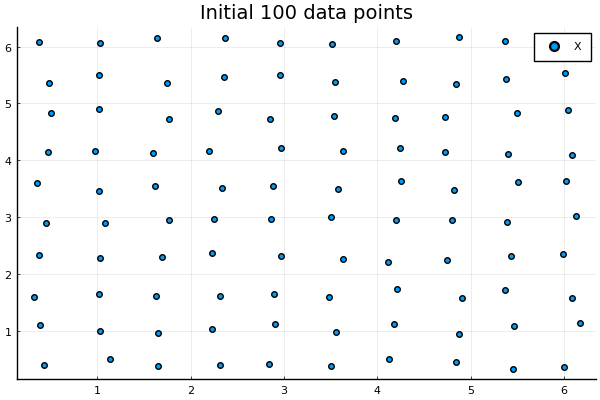

In [598]:
scatter(X[:,1], X[:,2]; label="X")
#scatter!(Y[:,1], Y[:,2]; label="Y")
title!("Initial $sample_size data points")

## Estimating the transfer operator
Having established a model for the dynamics, next we want to estimate the associated transfer operator,
$$
\mathcal{P} : L^1(X) \to L^1(X) .
$$
In particular, we are interested in this operator in the stochastic setting, characterised by the presence of a transition kernel $K(\cdot, \cdot)$. Hence $\mathcal{P}$ becomes
$$
 \mathcal{P} f(y) = \int_X K(S(x), y ) f(x) \, \mathrm{d}x .
$$
To estimate this infinite-dimensional operator, we will need to work in a finite-dimensional subspace of $L^1(X)$, which we call $V$. Since $\mathcal{P}$ is linear, it will then suffice to compute its action on a basis. This will allow us to construct a square matrix $P$, which we will take to be our estimate of $\mathcal{P}$, in that $P(V) = \mathcal{P}(V)$.

### A finite basis
But which subspace $V \subset L^1(X)$ do we choose? The natural thing to do is to is let the dataset drive the choice of $V$. Concretely, we will define a set of $N$ Gaussian functions $\{\varphi_n \}_{n=1}^N$, of the form
$$
\varphi_n (x) = \phi (x - x_n) := \exp \left( - \frac{\| x - x_n \|^2}{\epsilon^2} \right)
$$
where $\epsilon$ is a bandwidth parameter, and each $x_n$ sets the location of each $\varphi_n$. This is to say, the basis functions will be scattered across the phase space according to the positions of the $\{x_n \}_{n=1}^N$. The set $\{\varphi_n \}_{n=1}^N$ is then taken as a basis for $H$.
$$
V = \operatorname{span} \left( \{\varphi_n \}_{n=1}^N \right)
$$

In [599]:
basis_locs = X;
n_bases = sample_size;

The value chosen for $\epsilon$ is an exogenous parameter, and will clearly influence the structure of $H$. To ensure that we get sufficient coverage of the phase space with our basis $\{ \varphi_n \}_{n=1}^N$, we will set it to the maximum nearest-neighbour distance. This will also affect the value of the integral $\int_X \varphi_n (x) \, \mathrm{d}x = c = \pi \epsilon^2$.

In [600]:
ϵ = max_NN_distance(X);
c = π * ϵ^2;
println("Calculated value for ϵ: $ϵ")

Calculated value for ϵ: 0.6996031534503746


Having defined this basis $\{\varphi_k \}_{k=1}^K$, we can use it to approximate any function in $L^1(X)$ by simply taking linear combinations. For example:

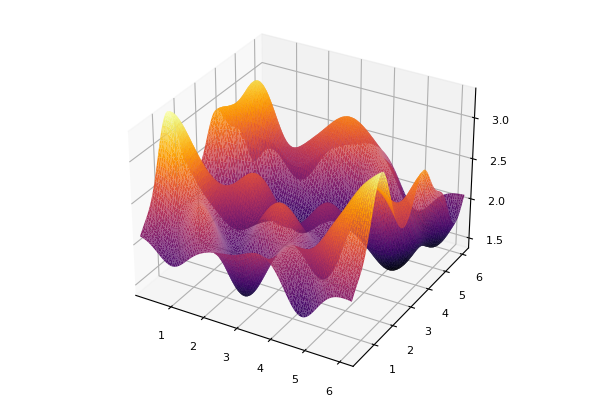

In [601]:
β = rand(n_bases);
test_surface = basis_combination(grid, basis_locs, φ, ϵ, β);
surface(grid[:,1], grid[:,2], test_surface; legend=false)

We will also be interested in the best possible approximation of the known invariant density for the standard map, which is the constant function (in this case, with value $f = \frac{1}{(2\pi)^2} \approx 0.025$). This is to say, we desire an approximation of Lebesgue measure with respect to the basis $\{ \varphi_n \}_{n=1}^N$. The relevant scalars here $\{ \eta_i \}_{i=1}^B$ will be equal to the output of the below optimisation procedure.

### Numerical integration
So we have chosen the subspace $V$. In order to estimate the integral
$$
    \mathcal{P} f(y) = \int_X k (S(x), y) f(x) \, \mathrm{d}x ,
$$
for some arbitrary function $f\in V$ we will also need an approximate Lebesgue measure, with respect to $\mathrm{d}x$. We will do this with a weighted combination of $\delta$-measures at each $x_n$; that is, we estimate Lebesgue measure as $\sum_{n=1}^N w_n \delta_{x_n}$. 

#### Optimisation
How do we choose the weights $w_n$? That is, how much weight should we assign to each point $x_n$? One strategy would be to estimate a whole lot of known integrals, for functions defined across the phase space, and then take some kind of average of all the weights that this process spits out. This can be achieved by introducing a class of test functions $\{ \psi_k (x) \}_{k=1}^K$, where each $\psi_k(x) = \phi(x - z_k)$ and the $z_k$ are location parameters for each function. We can then require that
$$
\sum_{n=1}^N w_n \psi_k (x_n) \approx \int_X \psi_k (x) \, \mathrm{d} x = c = \pi \epsilon^2
$$
simultaneously for each $k=1, \ldots, K$. In matrix form, this means solving the optimisation problem
\begin{equation}
\begin{bmatrix} \psi_1(x_1) & \cdots & \psi_1(x_N) \\ \vdots & & \\
\psi_K (x_1) &  & \psi_K(x_N) \end{bmatrix} \begin{bmatrix} w_1 \\ \vdots \\ w_N \end{bmatrix} \approx \begin{bmatrix} c \\ \vdots \\ c \end{bmatrix} . 
\label{matrix}
\end{equation}
We can formulate this as a nonnegative least squares optimisation problem
\begin{align*} & \min_{w \in \mathbb{R}^N} \| \Psi w - C \|_2^2 \\
&\text{s.t.} \ w_n \geq 0 \quad n =1, \ldots, N
\end{align*}
where $\Psi$, $w$ and $C$ are identified with the respective matrices and vectors in the previous display equation. However, given that the points $\{ x_n \}_{n=1}^N$ are uniformly scattered, it is likely that a lot of weights $w_n$ will be set to zero by this procedure. To anticipate this, we will penalise values of $w_n$ that are far away from the expected uniform weighting, $\bar{w} = \frac{m(X)}{N}$. Hence the optimisation problem becomes
\begin{align*} & \min_{w \in \mathbb{R}^N} \| \Psi w - C \|_2^2 + \kappa \| w - \bar{W} \|_2^2\\
&\text{s.t.} \ w_n \geq 0 \quad n =1, \ldots, N
\end{align*}
where $\kappa \in \mathbb{R}$ is some penalty parameter.

But what about the locations for these test functions $\{ \psi \}_{k=1}^K$? The most reasonable thing to do would be to space them on a grid, since this will mean we have nice uniform coverage of the phase space $X$.

In [602]:
test_function_grid_size = 50;
n_test_functions = test_function_grid_size ^ 2;
test_function_locs = creategrid(0, range, test_function_grid_size);

For the sake of consistency, we take the same value for $\epsilon$ for these test functions as that for the basis functions.

In [603]:
ϵ_test_functions = ϵ;

We can then calculate the matrix $\Psi$ as the evaluation of every test function against every data point.

In [604]:
Ψ = evaluate_funcs(X, test_function_locs, φ, ϵ_test_functions);

With a few more vectors, we are ready to run the optimisation routine.

In [605]:
c_test = π * ϵ_test_functions^2;
C = c_test * ones(n_test_functions);
w_av = (range^2) / sample_size;

In [606]:
w, residual, objvalue = nnlsq_pen(Ψ, C, w_av, 0.0);

Academic license - for non-commercial use only - expires 2021-08-05
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2500 rows, 2600 columns and 242309 nonzeros
Model fingerprint: 0x28f86e35
Model has 2500 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.06s
Presolved: 2500 rows, 2600 columns, 242309 nonzeros
Presolved model has 2500 quadratic objective terms
Ordering time: 0.01s

Barrier statistics:
 Dense cols : 100
 AA' NZ     : 2.398e+05
 Factor NZ  : 2.522e+05 (roughly 4 MBytes of memory)
 Factor Ops : 2.477e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Ite

The weights should sum to close to $\mu(X) = (2\pi)^2$, since this is the area of the state space.

In [607]:
println("Total sum of weights: $(sum(w))")
println("Area of state space: $((2π)^2)")
println("Ratio: $(sum(w) / (2π)^2)")

Total sum of weights: 39.47659205645135
Area of state space: 39.47841760435743
Ratio: 0.99995375833134


We would also expect that the average weight is close to an equal tesselation of the state space, since all the data points are uniformly distributed.

In [608]:
println("Average weight: $(mean(w))")
println("Equal tesselation size: $(w_av)")

Average weight: 0.39476592056451354
Equal tesselation size: 0.3947841760435743


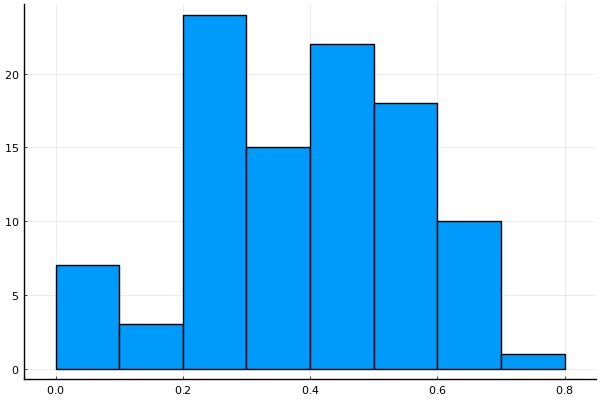

In [609]:
histogram(w; legend=false)

And most importantly, the weights should give us close to a constant function.

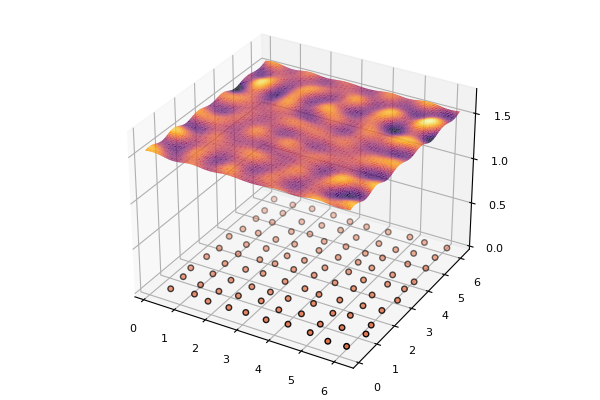

In [610]:
weighted_surface = basis_combination(grid, basis_locs, φ, ϵ, w); 
surface(grid[:,1], grid[:,2], weighted_surface; legend=false)
scatter!(X[:,1], X[:,2], zeros(sample_size))
zlims!(0, maximum(weighted_surface)*1.1)

This looks pretty good. It is clear that things get more variable in the regions with fewer datapoints.

#### Calculation
With these weights, we can now compute the integral $\mathcal{P}f(x)$. In particular, we are interested in computing $\mathcal{P}\varphi_n(x)$ for all $N$ basis functions, since this will clearly suffice in constructing $P$.
$$
\mathcal{P}\varphi_n(y) = \int_X k (S(x), y) \varphi_n(x) \, \mathrm{d}x 
$$
For convenience, we will use the stochastic kernel $K (x, y) = \rho (x - y) = \frac{1}{c} \phi (x-y)$. Hence under the image points, $K(S(x) , y )$ becomes in effect an image of the basis functions, with $k(S(x_m), y) = \frac{1}{c} \varphi_{y_m}$. So our estimation of the above integral becomes the discrete sum
$$
\mathcal{P}\varphi_n(y) \approx \sum_{m=1}^N \frac{1}{c} \left( w_m \cdot \varphi_n (x_m) \right)  \varphi_{y_m} (y)
$$

In [644]:
# Φ*w ./ c

Hence we can write each of the basis functions $\varphi_n$ as a linear combination of basis functions centered at the image points, $\{ \varphi_{y_n} \}_{n=1}^N$. But we obviously want to be able to write each $\mathcal{P} \varphi_n$ as just a linear combination of the $\varphi_n$. To do this, we will need to 'project' back onto the original subspace $H$ by writing each $\varphi_{y_m}$ itself as a linear combination of the $\varphi_n$.
$$
 \varphi_{y_m} (y) = \sum_{n=1}^N \gamma_n \varphi_n (y)
$$

Where do the weights $\gamma_n$ come from? We will need to calculate them according to a procedure suggested by Ding, Eifler, and Rhee. This says that
$$
\varphi_{y_m} (y) \approx Q \varphi_{y_m} (y) = \sum_{j=1}^N \left( \int_{V_j} c_j \varphi_{y_m} \right) \varphi_j (y) .
$$
Each of these integrals is computed over a Voronoi tesselation of the state space $X$, such that each $V_j$ corresponds to a particular basis function $\varphi_j$. What about the weights $c_j$? Per the same source, these must satisfy
\begin{align*}
    \sum_{j=1}^N \langle \varphi_j , \mathbb{1} \rangle c_j \mathbb{1}_{V_j} &= \mathbb{1} \\
    \sum_{j=1}^N c \cdot c_j \mathbb{1}_{V_j} &= \mathbb{1} \\
    \therefore c_j &= \frac{1}{c}
\end{align*}
so will be uniform across the integrals.

For the sake of computation, `integrate_phiy` is just used to compute the $N$ integral values for each image point, omitting the $c_j$. The results are stored in the matrix $\Xi$.

In [612]:
Ξ = integrate_phiy(Y, basis_locs, range, 100, φ, ϵ);

We will also need an evaluation matrix of all sample points against all basis functions, which we denote $\Phi$.

In [613]:
Φ = evaluate_funcs(X, basis_locs, φ, ϵ);

This is now everything we need to compute the matrix $P$.

In [614]:
P = construct_P(w, Φ, Ξ, c);

In [615]:
display(P)

100×100 Matrix{Float64}:
 0.019984    0.00447498  0.0014175    …  0.0112623    0.00922651  0.00648078
 0.0533423   0.0175406   0.00253312      0.00184829   0.00510267  0.0155775
 0.0737871   0.0290219   0.00454922      0.0035745    0.00603295  0.0223121
 0.0398757   0.0210471   0.00436883      0.018219     0.0242725   0.0178585
 0.0152955   0.00786918  0.00197716      0.0322608    0.0664456   0.0342655
 0.014657    0.00549262  0.00119976   …  0.036605     0.0971158   0.0546611
 0.0184192   0.00922066  0.00192111      0.0180702    0.0460674   0.027142
 0.0077088   0.00506088  0.00164696      0.0104072    0.005517    0.00334046
 0.00250575  0.0020677   0.00118123      0.0215356    0.00663493  0.0014725
 0.00501569  0.00299238  0.00261276      0.0232454    0.0111357   0.00252313
 0.0404665   0.0032109   0.00015801   …  0.0170768    0.0172581   0.0126956
 0.0399938   0.00561933  0.000502817     0.00357954   0.00834121  0.0100518
 0.0255941   0.00747956  0.000963363     0.00197743   0.00278

We will need to perform a minor adjustment to ensure that $P$ is row-stochastic.

In [616]:
#P_raw = P;
#row_sums = sum(P, dims=2);
#for row in 1:n_bases
#     for col in 1:n_bases
#         P[row,col] = P[row,col] / row_sums[row];
#     end;
# end;

## Checking the results
Now that we have an estimate of $P$, we can start appraising it.

### Plotting the spectrum
We expect that $P$ should have a leading unit eigenvalue, and all the remaining eigenvalues should have modulus less than one.

In [617]:
λ, Λ = ordered_eigendecomp(P);

In [618]:
display(λ[1])

1.0016624205855569 + 0.0im

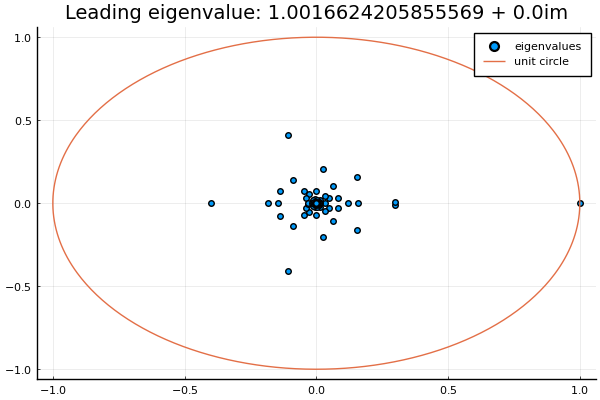

In [619]:
u, v = real.(λ), imag.(λ);
xc, yc = cos.(LinRange(0, 2π, 500)), sin.(LinRange(0, 2π, 500));

scatter(u, v, label="eigenvalues")
plot!(xc, yc, label="unit circle")
title!("Leading eigenvalue: $(λ[1])")

Happily, this is indeed the case.

### Row stochasticity
We also expect that the estimate should be row-stochastic.

In [620]:
row_sums = sum(P, dims=2)[:];

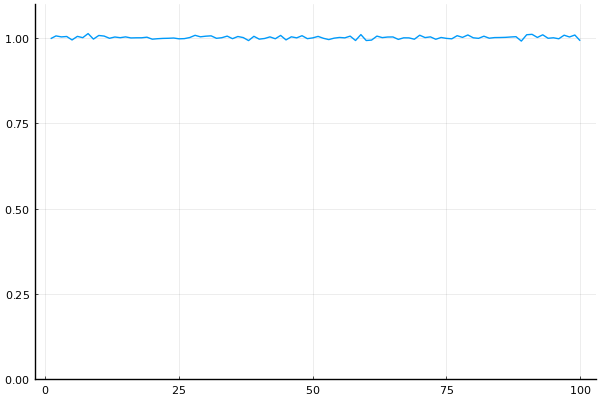

In [621]:
plot(row_sums; ylims=(0,1.1), legend=false)

Row sums are very close to constant.

### Invariant density
We know that the leading eigenvector will specify the linear combination of basis functions which represents the invariant density. We may need to take the absolute value, since the solutions to the eigenproblem may flip the signs.

In [622]:
α = real.(Λ[:,1]);
α = abs.(α);

In [623]:
display(α)

100-element Vector{Float64}:
 0.09964953751429904
 0.10044300827224184
 0.10018329785896501
 0.10034156649237135
 0.09930759815948965
 0.1003369522214557
 0.09990855240887853
 0.10108829656863269
 0.09952455328681316
 0.10059943830472784
 0.10045119255575095
 0.09975399635099036
 0.10010896721612121
 ⋮
 0.0990430665900101
 0.10093069601239399
 0.10096624705795587
 0.100006007500156
 0.10080567656590887
 0.09980366175694566
 0.09991755470849556
 0.0996326710639249
 0.10066569568360713
 0.10015722455781668
 0.10073170188370824
 0.099086080246165

We will nevertheless need to normalise the coordinates of this eigenvector such that it describes a density.

In [624]:
estimated_invariant_density = basis_combination(grid, basis_locs, φ, ϵ, α);
estimated_invariant_density_integral = ( (range^2) / n_gridpoints ) * sum(estimated_invariant_density) ;
α_normalised = α / estimated_invariant_density_integral;
estimated_invariant_density_normalised = basis_combination(grid, basis_locs, φ, ϵ, α_normalised); 

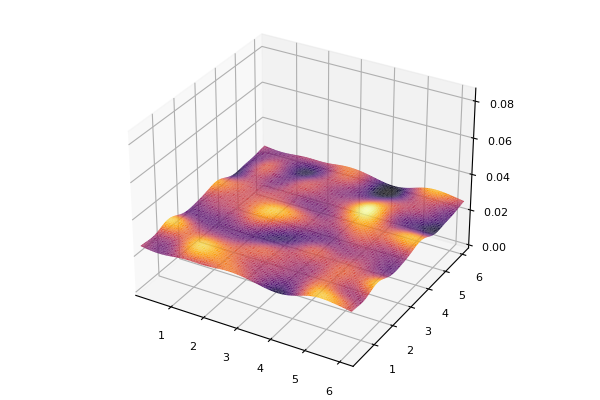

In [625]:
surface(grid[:,1], grid[:,2], estimated_invariant_density_normalised; legend=false)
zlims!(0, maximum(estimated_invariant_density_normalised)*3)

This looks flat-ish, which is good, since we know that the invariant density under the standard map is just the constant function. This result can be quantified by computing the $L^p$ norm of the difference between our estimated invariant density, denoted $\hat{f}^*$, and the known true invariant density, which we denote $f^*$. Or rather, we can compare $\hat{f}^*$ with the best possible representation of $f^*$ with respect to the basis we have chosen, which we denote $f^\dagger$.

In [626]:
weighted_surface_integral = ( (range^2) / n_gridpoints ) * sum(weighted_surface);
η = w / weighted_surface_integral;
approximate_invariant_density = basis_combination(grid, basis_locs, φ, ϵ, η);

In [627]:
estimation_gap = estimated_invariant_density_normalised - approximate_invariant_density;

In [628]:
estimation_l1 = Lp_norm(estimation_gap; p="one");
estimation_l2 = Lp_norm(estimation_gap; p="two");
estimation_l∞ = Lp_norm(estimation_gap; p="∞");

println("L1 norm of estimation difference: $estimation_l1")
println("L2 norm of estimation difference: $estimation_l2")
println("L∞ norm of estimation difference: $estimation_l∞")

L1 norm of estimation difference: 0.03154564133085568
L2 norm of estimation difference: 0.006290337735602166
L∞ norm of estimation difference: 0.002948041825860514


In [629]:
constant_function = ones(n_gridpoints) / (range^2);

In [630]:
approximation_gap = approximate_invariant_density - constant_function;

In [631]:
approximation_l1 = Lp_norm(approximation_gap; p="one");
approximation_l2 = Lp_norm(approximation_gap; p="two");
approximation_l∞ = Lp_norm(approximation_gap; p="∞");

println("L1 norm of approximation difference: $approximation_l1")
println("L2 norm of approximation difference: $approximation_l2")
println("L∞ norm of approximation difference: $approximation_l∞")

L1 norm of approximation difference: 0.005292640727350914
L2 norm of approximation difference: 0.0010823031647635292
L∞ norm of approximation difference: 0.0006531555463741949


Looks like we have a pretty good approximation setup.

### Integral preservation and evolving forward a density
Last, we try directly evolving forward a density using $P$, and use this as an occasion to check that indeed preserves integrals. We start with a random function $f \in V$, where $f = \sum_{n=1}^N \beta_n \varphi_n$.

In [632]:
β = η + Int.(rand(n_bases) .> 0.8);
initial_density = basis_combination(grid, basis_locs, φ, ϵ, β);
initial_density_integral = ( (range)^2  / n_gridpoints ) * sum(initial_density);
println("Estimate of initial integral: $initial_density_integral")

Estimate of initial integral: 33.29034491359045


In [633]:
β = β / initial_density_integral;
initial_density = basis_combination(grid, basis_locs, φ, ϵ, β);
initial_density_integral = ( (range)^2  / n_gridpoints ) * sum(initial_density);
println("Estimate of normalised integral: $initial_density_integral")

Estimate of normalised integral: 0.9999999999999999


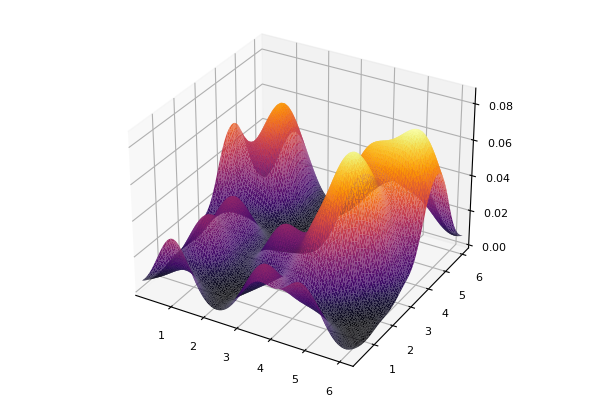

In [634]:
surface(grid[:,1], grid[:,2], initial_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

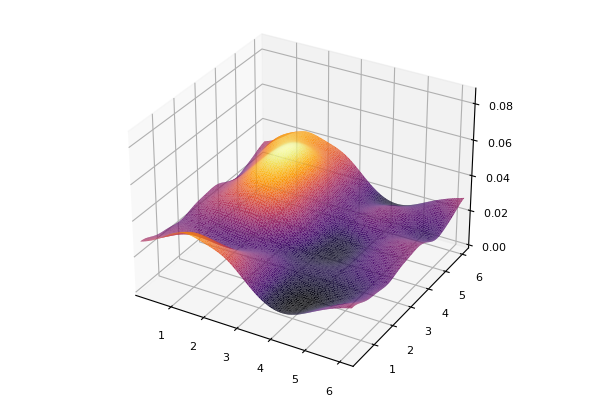

In [635]:
β1 = P * β;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β1);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [636]:
integral = (2π)^2 * sum(evolved_density) / n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 0.9949262717343965


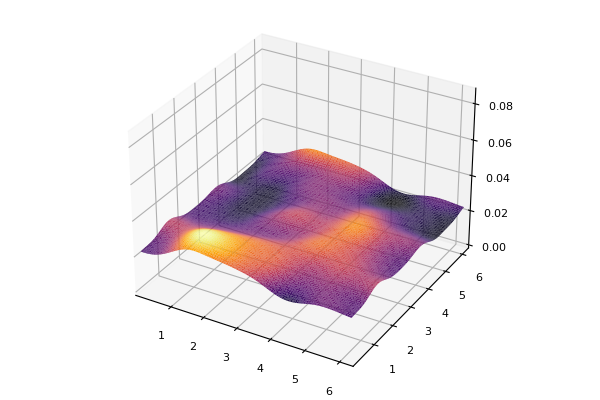

In [637]:
β2 = P * β1;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β2);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [638]:
integral = (2π)^2 * sum(evolved_density) / n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 1.0050614120040517


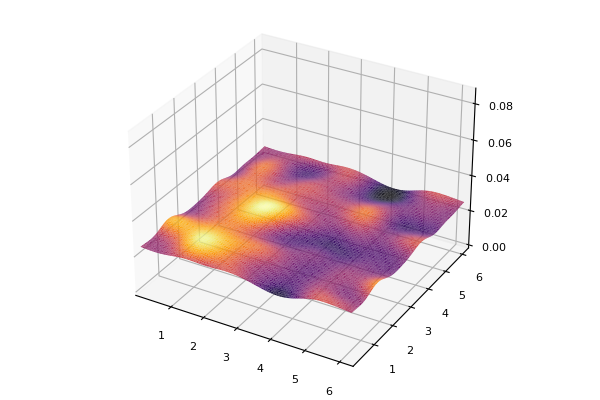

In [639]:
β3 = P * β2;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β3);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [640]:
integral = (2π)^2 * sum(evolved_density) / n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 1.0085593862270512


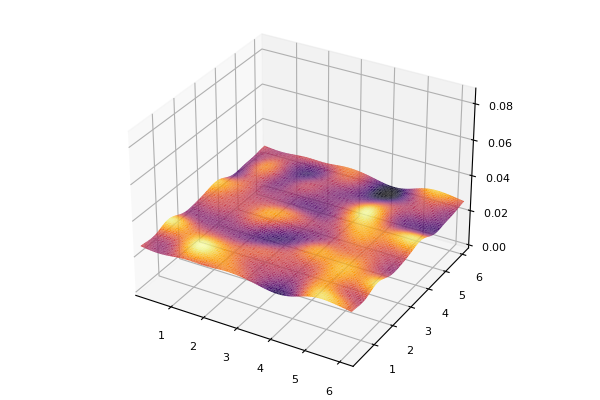

In [641]:
β4 = P * β3;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β4);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [642]:
integral = (2π)^2 * sum(evolved_density) / n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 1.0087947077141812


We can just see the invariant density start to emerge, and happily integrals are preserved.

## Conclusions
We have a reasonably functional procedure. Now it is time to experiment with different model parameters.